### Enterprise software documentation: clustering on word count distributions

###### Home work 3 extension
- Clean some sitemaps
    - Non english language content removed from Autodesk
    - Atlassian sitemap crawled on public docs only
    - Microsoft product support docs added with main docs subdomain site to better represent range
        - https://support.office.com/
        - https://support.microsoft.com/
        - https://docs.microsoft.com/
    - Added teradata sitemap for complete set
  
- Takes more columns from the sitemap files e.g. page descriptions/meta data, path depth and link types (inbound, outbount, external)

- Repeats last Homework 2 cluster analysis on the average word length of the pages with the cleaner sitemaps 

- Decision tree for article length, path depth etc



###### Workbook steps:
    1. Read in docs sitemaps
        * a) Notes on sitemaps
        * b) Check requests status
        * c) Remove bad requests
        * d) Remove word counts < 50
    2. Distributions of article length
        * a) Plot doc set article length distributions
        * b) Descriptive statistics of article word count
        * c) Test distribution normalility/ pairwise - not finished   
    3. ~~Regression tests - RANSAC vs theil-sen~~ [x]
        * a) Load company data add docs metrics [x]
        * b) Path depth and in/out/ext links, products, article length & employee number [x]
	* b) ~~Scatter plots [x]~~
    4. Cluster analysis on article length K-means vs DBscan
        * test best cluster number for K-means
        * Test models 
    5. [TO DO] Cluster analysis on other metrics 
    - metrics:
         * Inbound-outbound links
         * Path depth
         * Product number
         * Article length distributions
         * Website size (page count)
         * Number and range of directories
         

**Content factors to explore**

| Name | Description |
| :------ | :----------------------------- |
| Task focused | How task focused is the text, both words (verbs/nouns) and structure. |
| Verbosity | How long are sentences? Word length, adjectives, common usage, and repetion | 
| Formality | Formal vs informal language, colloquisms, contractions, pronouns etc | 
| Internal Refering | How many links within docs set/doc set size | 
| Outside referals | How many links in the doc refer to external domains/total links | 
| Site bredth & depth | Number of folders, size, depth of path | 
| Topic bredth & depth  | Range of distinct H1,H2, keywords, product folders | 
| Sentiment | How neutral, positive or negetive are the words used? | 
| Formulaic | Are all the articles/folders in the docsset of similar length, structure, tone or are they varied? | 



** Next steps **
- NLP dimensions for above as columns
- Look at within the docs set for clusters
    * Models predicting doc type within a set - dev/admin/KB vs consumer docs,  Microsoft, Atlassian & other sets (that contain diff docs types)
    
      

##### Install python libraries

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
from collections import Counter
import sklearn.linear_model
import sklearn.cluster
import sklearn.datasets
from mpl_toolkits.mplot3d import Axes3D
#plt.rcParams.update({'font.size': 20})

#### 1. Read in docs sitemaps
**a) Notes on sitemaps**
- Read sitemaps for Fortune 500 consumer enterprise software companies with proportion of software revenue >75% + Atlassian and some smaller single product companies
- Maps made with web crawler GUI 'Screaming frog SEO' https://www.screamingfrog.co.uk/
- Easy to monitor & control (pause, save) massive website crawls (Atlassian CAC took 12 hours +)
- In the terminal/bash command window type 'defaults write uk.co.screamingfrog.seo.spider Memory 8g' to allocate lots of memory while running big crawls
- Filter map for HTML only (can filter for pdf later) and export as .csv file

List of sitemap urls & csv files
- Games, entertainment docs excluded
- Also excluded are docs sets behind a login
- Autodesk has non-english language directories sitting on the same level as enmglish content which will need to be removed
- **Note** Read-ins take two runs on initial load for some reason

In [2]:
# Fortune 500 top 5 enterprise software companies sw revenue >75%
smap01a = pd.read_csv('data/docsurls_microsoft.csv') # [√] https://docs.microsoft.com/en-us/
smap01b = pd.read_csv('data/docsurls_microsoftOffice.csv') # [√] https://support.office.com
frms01 = [smap01a,smap01b] 
smap02 = pd.read_csv('data/docsurls_oracle.csv') # [√] https://docs.oracle.com/en/
smap03 = pd.read_csv('data/docsurls_salesforce.csv') # [√] https://help.salesforce.com/
smap04 = pd.read_csv('data/docsurls_symantec.csv') # [√] https://support.symantec.com/en_US/
smap05a = pd.read_csv('data/docsurls_adobe_p1.csv') # [√] https://docs.adobe.com/
smap05b = pd.read_csv('data/docsurls_adobe_p2.csv')
frms05 = [smap05a,smap05b] 
smap06 = pd.read_csv('data/docsurls_intuit.csv') # [√] https://community.intuit.com/ or https://developer.intuit.com/docs/
smap07 = pd.read_csv('data/docsurls_CA.csv') # [BTW?] http://www.ca.com/us/support/ca-support-online/
smap08a = pd.read_csv('data/docsurls_teradata_p1.csv') # [√] http://www.info.teradata.com/
smap08b = pd.read_csv('data/docsurls_teradata_p2.csv') # [√] http://www.info.teradata.com/
smap08c = pd.read_csv('data/docsurls_teradata_p3.csv') # [√] http://www.info.teradata.com/
frms08 = [smap08a,smap08b,smap08c] 
smap09 = pd.read_csv('data/docsurls_autodesk_EN.csv') # [√] https://knowledge.autodesk.com/support
smap10 = pd.read_csv('data/docsurls_synopsis.csv') # [BTW?] http://www.synopsys.com/Support/
smap11 = pd.read_csv('data/docsurls_akamai.csv') # [BTW?] https://developer.akamai.com/
smap12 = pd.read_csv('data/docsurls_nuance.csv') # [BTW?] http://www.nuance.com/support/

/Users/amandaparker/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/amandaparker/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/amandaparker/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/amandaparker/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity

In [3]:
# Atlassian and single-product competitors
smap13 = pd.read_csv('data/docsurls_atlassian_PUB.csv') # [√] https://confluence.atlassian.com/
smap14 = pd.read_csv('data/docsurls_trello.csv') # [√] http://help.trello.com/
smap15 = pd.read_csv('data/docsurls_slack.csv') # [√] https://get.slack.help/
smap16 = pd.read_csv('data/docsurls_github.csv') # [√] https://help.github.com/ or https://guides.github.com/
smap17 = pd.read_csv('data/docsurls_dropbox.csv') # [√] https://www.dropbox.com/help
#smap18 = pd.read_csv('data/docsurls_atlassianDAC.csv') # [] https://developer.atlassian.com/

In [4]:
smap01 = pd.concat(frms01)
smap05 = pd.concat(frms05)
smap08 = pd.concat(frms08)

In [5]:
smap_idx = [smap01,smap02,smap03,smap04,smap05,smap06,smap07,smap08,smap09,smap10,smap11,smap12,smap13,smap14,
            smap15,smap16,smap17]
clen = len(smap_idx)
print 'Number of company docs:', clen

Number of company docs: 17


**b) Remove bad links and <50 word pages**
- 200, 302 vs other
- Look at request status and remove bad requests from docs sets

In [6]:
tmpcnt = {}
tmpok = {}
tmpbad = {}
for k in range(0,clen):
    tmpsmp = smap_idx[k]
    c = Counter(tmpsmp['Status'])
    tmpcnt[k] = len(tmpsmp['Status'])
    tmpok[k] = c['OK'] or c['Found']
    tmpbad[k] = tmpcnt[k]-tmpok[k]
for r in range(1,clen):
    tmp = smap_idx[r]
    tmpidx = tmp[tmp['Status']=='OK']
    smap_idx[r] = tmpidx

** c) Remove word counts < 50 **

In [7]:
for p in range(0,clen):
    tmp = smap_idx[p]
    tmpidx = tmp[tmp['Word Count']>51]
    smap_idx[p] = tmpidx

**d) Number of html pages in each doc site**
How many html files are there? 

In [8]:
slen = 0
savelen = {}
for n in range(0,len(smap_idx)):
    slen = slen + len(smap_idx[n])
    savelen[n] = len(smap_idx[n])
pages = {'pages':savelen}
docpagecnt = pd.DataFrame(pages)
print 'Total html pages counted: ',slen

Total html pages counted:  301406


** e) Graph total docs pages**

Number of companies: 17


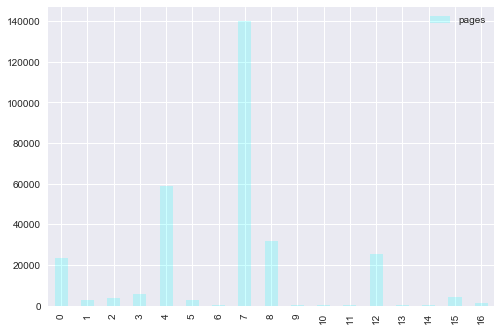

In [9]:
docpagecnt.plot.bar(color='cyan', alpha=0.2)
print 'Number of companies:', len(smap_idx)

#### 2. Distributions of article length
Look at how article length is distributed - are a companies docs all around the same length or is article length more variable (more widely distributed)?

In [10]:
wc = {}
gwc = {}
xtmp = {}
bins=50
for w in range(0,len(smap_idx)):
    tmp = smap_idx[w]
    xtmp[w] = np.array(tmp['Word Count'])
    #color = cols[w]    
    gwc[w] = sum(xtmp[w])
    wc[w] = tmp['Word Count'].mean()
print 'Total word count for the websites: ', gwc

Total word count for the websites:  {0: 18593826, 1: 1433127, 2: 2179135, 3: 4743648, 4: 33481296, 5: 7902193, 6: 51786, 7: 30879286, 8: 15332397, 9: 214956, 10: 184907, 11: 68113, 12: 77561568, 13: 54805, 14: 201221, 15: 1459792, 16: 1300041}


** a) Plot doc set article length distributions**

In [35]:
cols_hex = np.array(['#E50004','#E22B00','#DF5B00','#DD8900','#DAB700','#CDD800','#9CD500','#6DD300','#3FD000','#12CE00'
              ,'#00CB19','#00C944','#00C66E','#00C496','#00C1BE','#0098BF','#007EBF'])
#,'#0065BF','#004BBF','#0032BF','#0018BF','#0000BF','#1900BF','#3300BF','#4C00BF','#6500BF'
c = cols_hex
len(cols_hex)
clen

17

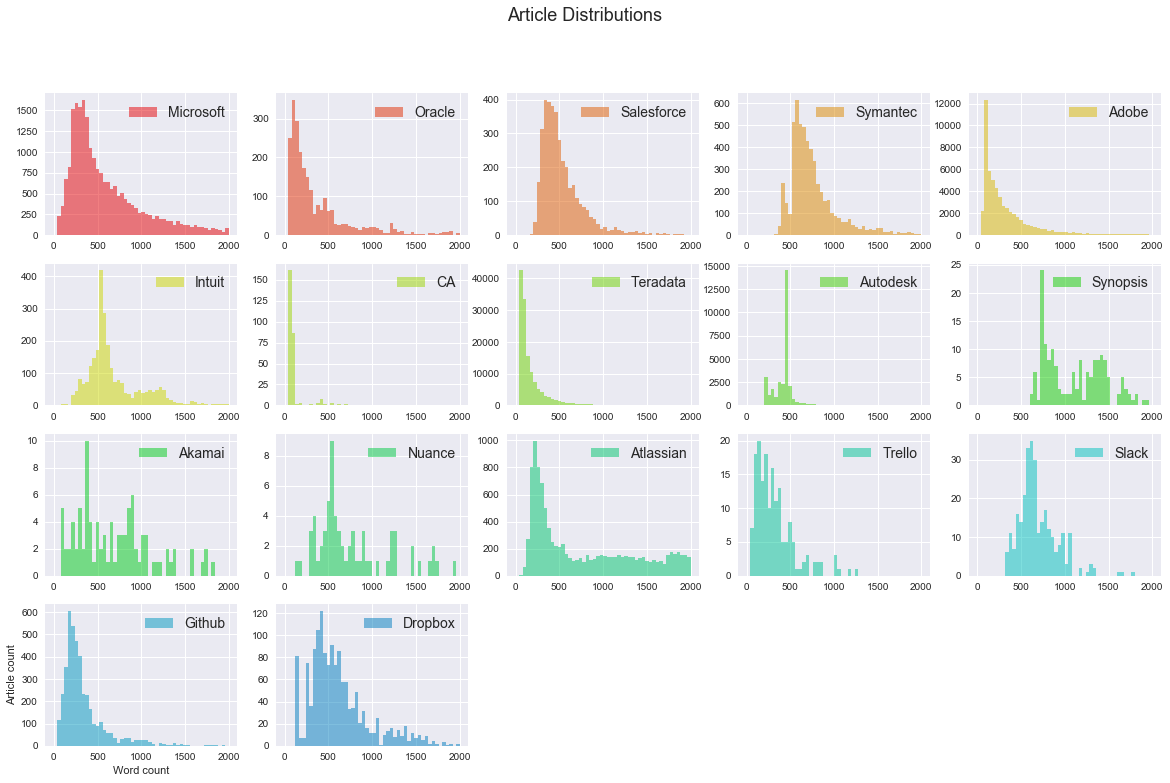

In [42]:
plt.figure(figsize=(20, 12))
plt.suptitle('Article Distributions',  fontsize=18)
plt.ylabel('Article count',  fontsize=18)
plt.subplot(451)
plt.hist(xtmp[0], bins, range=(0,2000), alpha=0.5, label='Microsoft', color=c[0])
#plt.title('Microsoft')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(452)
plt.hist(xtmp[1], bins, range=(0,2000), alpha=0.5, label='Oracle',color=c[1])
# plt.title('Oracle')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(453)
plt.hist(xtmp[2], bins, range=(0,2000), alpha=0.5, label='Salesforce',color=c[2])
# plt.title('Salesforce')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(454)
plt.hist(xtmp[3], bins, range=(0,2000), alpha=0.5, label='Symantec',color=c[3])
# plt.title('Symantec')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(455)
plt.hist(xtmp[4], bins, range=(0,2000), alpha=0.5, label='Adobe', color=c[4])
# plt.title('Adobe')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(456)
plt.hist(xtmp[5], bins, range=(0,2000), alpha=0.5, label='Intuit',color=c[5])
# plt.title('Intuit')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(457)
plt.hist(xtmp[6], bins, range=(0,2000), alpha=0.5, label='CA',color=c[6])
# plt.title('CA')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(458)
plt.hist(xtmp[7], bins, range=(0,2000), alpha=0.5, label='Teradata',color=c[7])
# plt.title('Teradata')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(459)
plt.hist(xtmp[8], bins, range=(0,2000), alpha=0.5, label='Autodesk',color=c[8])
# plt.title('Autodesk')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(4,5,10)
plt.hist(xtmp[9], bins, range=(0,2000), alpha=0.5, label='Synopsis',color=c[9])
# plt.title('Synopsis')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(4,5,11)
plt.hist(xtmp[10], bins, range=(0,2000), alpha=0.5, label='Akamai',color=c[10])
# plt.title('Akamai')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(4,5,12)
plt.hist(xtmp[11], bins, range=(0,2000), alpha=0.5, label='Nuance',color=c[11])
# plt.title('Nuance')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(4,5,13)
plt.hist(xtmp[12], bins, range=(0,2000), alpha=0.5, label='Atlassian',color=c[12])
# plt.title('Atlassian')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(4,5,14)
plt.hist(xtmp[13], bins, range=(0,2000), alpha=0.5, label='Trello',color=c[13])
# plt.title('Trello')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(4,5,15)
plt.hist(xtmp[14], bins, range=(0,2000), alpha=0.5, label='Slack',color=c[14])
# plt.title('Slack')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(4,5,16)
plt.xlabel('Word count')
plt.ylabel('Article count')
plt.hist(xtmp[15], bins, range=(0,2000), alpha=0.5, label='Github',color=c[15])
# plt.title('Github')
plt.legend(loc='upper right',fontsize=14)
plt.subplot(4,5,17)
plt.hist(xtmp[16], bins, range=(0,2000), alpha=0.5, label='Dropbox',color=c[16])
# plt.title('Dropbox', fontsize=20)
plt.legend(loc='upper right',fontsize=14)
plt.savefig('graphs/ALL_ArticleLengthDistributions_01.png')
plt.show()

** b) Descriptive statistics of article word count**

In [13]:
max = len(smap_idx)
means = {}
outlinks = {}
inlinks = {}
extoutlinks = {}
variances = {}
skewnesss = {}
kurtosiss = {}
pathdepth = {}
for s in range(0,max):
    tmp = {}
    tmp = smap_idx[s]
    sd = stats.describe(tmp['Word Count'])
    sd1 = stats.describe(tmp['Outlinks'])
    sd2 = stats.describe(tmp['Inlinks'])
    sd3 = stats.describe(tmp['External Outlinks'])
    sd4 = stats.describe(tmp['Level'])
    #print sd.mean, sd.variance
    means[s] = sd.mean
    variances[s] = sd.variance
    skewnesss[s] = sd.skewness
    kurtosiss[s] = sd.kurtosis
    outlinks[s] = sd1.mean
    inlinks[s] = sd2.mean
    extoutlinks[s] = sd3.mean
    pathdepth[s] = sd4.mean

### 3. Format dataframe 
** a) Load company data add additional docs metrics**

In [14]:
comps = pd.read_csv('data/ent_softwarecompanies.csv')

In [15]:
r01 = comps[comps['Company']=='Microsoft']
r02 = comps[comps['Company']=='Oracle']
r03 = comps[comps['Company']=='Salesforce']
r04 = comps[comps['Company']=='Symantec']
r05 = comps[comps['Company']=='Adobe']
r06 = comps[comps['Company']=='Intuit']
r07 = comps[comps['Company']=='CA']
r08 = comps[comps['Company']=='Teradata']
r09 = comps[comps['Company']=='Autodesk']
r10 = comps[comps['Company']=='Synopsis']
r11 = comps[comps['Company']=='Akamai']
r12 = comps[comps['Company']=='Nuance']
r13 = comps[comps['Company']=='Atlassian']
r14 = comps[comps['Company']=='Trello']
r15 = comps[comps['Company']=='Slack']
r16 = comps[comps['Company']=='Github']
r17 = comps[comps['Company']=='Dropbox']

In [16]:
df = pd.DataFrame()
cdf = []
cdf = df.append([r01,r02,r03,r04,r05,r06,r07,r08,r09,r10,r11,r12,r13,r14,r15,r16,r17])
cdf.index = [[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]]

In [17]:
tc = pd.Series(gwc)
sl = pd.Series(savelen)
awc = pd.Series(means)
wcv = pd.Series(variances)
wcs = pd.Series(skewnesss)
wck = pd.Series(kurtosiss)

In [18]:
cdf['docs_total_pages']=sl
cdf['docs_total_words']=tc
cdf['docs_artlen_mean']=awc
cdf['docs_artlen_variance']=wcv
cdf['docs_artlen_skewness']=wcs
cdf['docs_artlen_kurtosis']=wck

In [19]:
ol = pd.Series(outlinks)
il = pd.Series(inlinks)
eol = pd.Series(extoutlinks)
cdf['Outlinks']=ol
cdf['Inlinks']=il
cdf['ExtOutlinks']=eol

In [20]:
pdpth = pd.Series(pathdepth)
cdf['PathDepth']=pdpth

In [21]:
ndf = pd.DataFrame(cdf)
droplist = ['Company', 'Index','shareticker','shareprice','RevenueM2015','Website','Documentation','Type','ProductList']
ndf.drop(ndf[droplist],inplace=True,axis=1)
#ndf.dropna()

** b) Scatter plots**

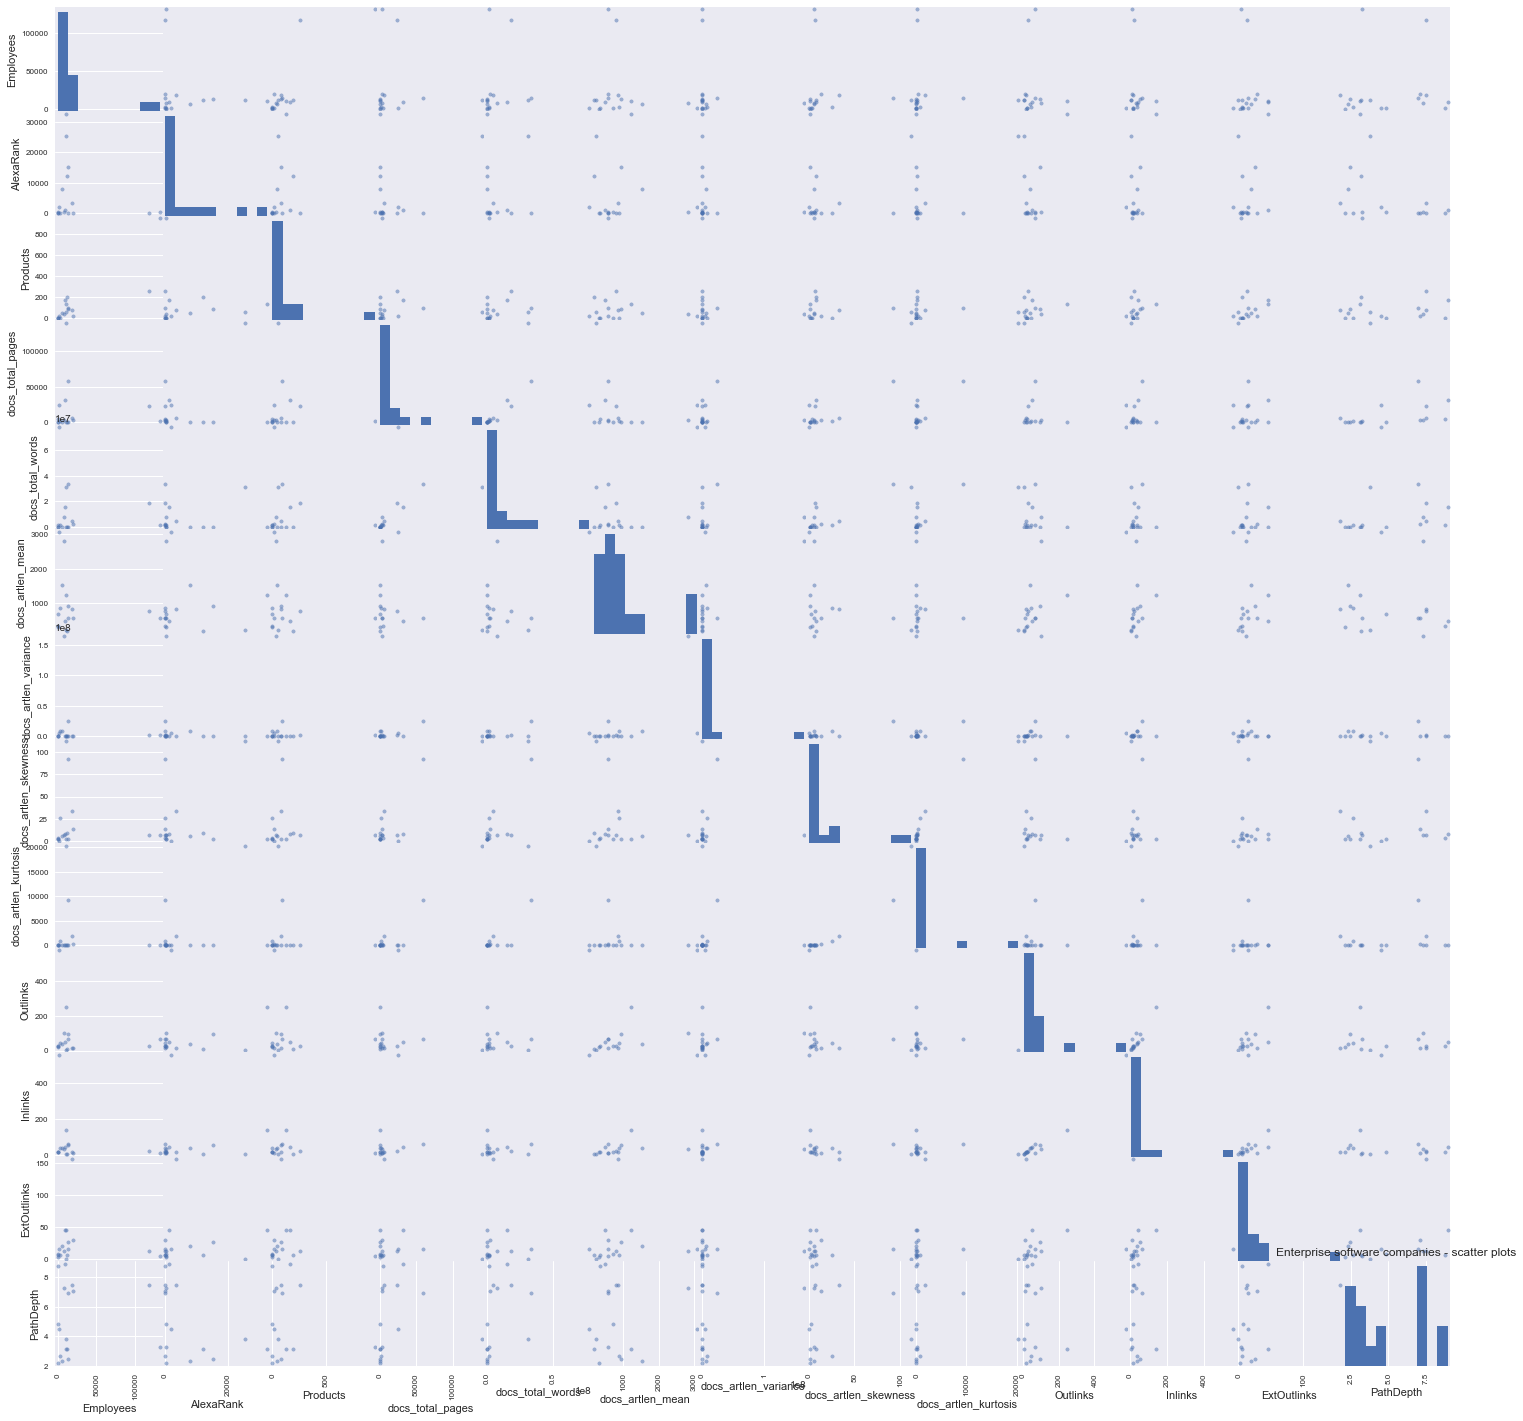

In [22]:
fig = pd.scatter_matrix(ndf, figsize=(25,25))
plt.title('Enterprise software companies - scatter plots')
plt.savefig('graphs/ALL_ScatterPlots_01.png')

** c) Normalise ranges **

In [23]:
from sklearn import preprocessing
normdf = ndf
print len(ndf)
for k in range(0,13):
    x = ndf[ndf.columns[k]]
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_normalized = pd.DataFrame(x_scaled)
    nm = str(ndf.columns[k])
    print nm
    normdf[nm] = df_normalized

17
Employees
AlexaRank
Products
docs_total_pages
docs_total_words
docs_artlen_mean
docs_artlen_variance
docs_artlen_skewness
docs_artlen_kurtosis
Outlinks
Inlinks
ExtOutlinks
PathDepth


/Users/amandaparker/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/amandaparker/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/amandaparker/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/U

** d) Normalised scatter plot **

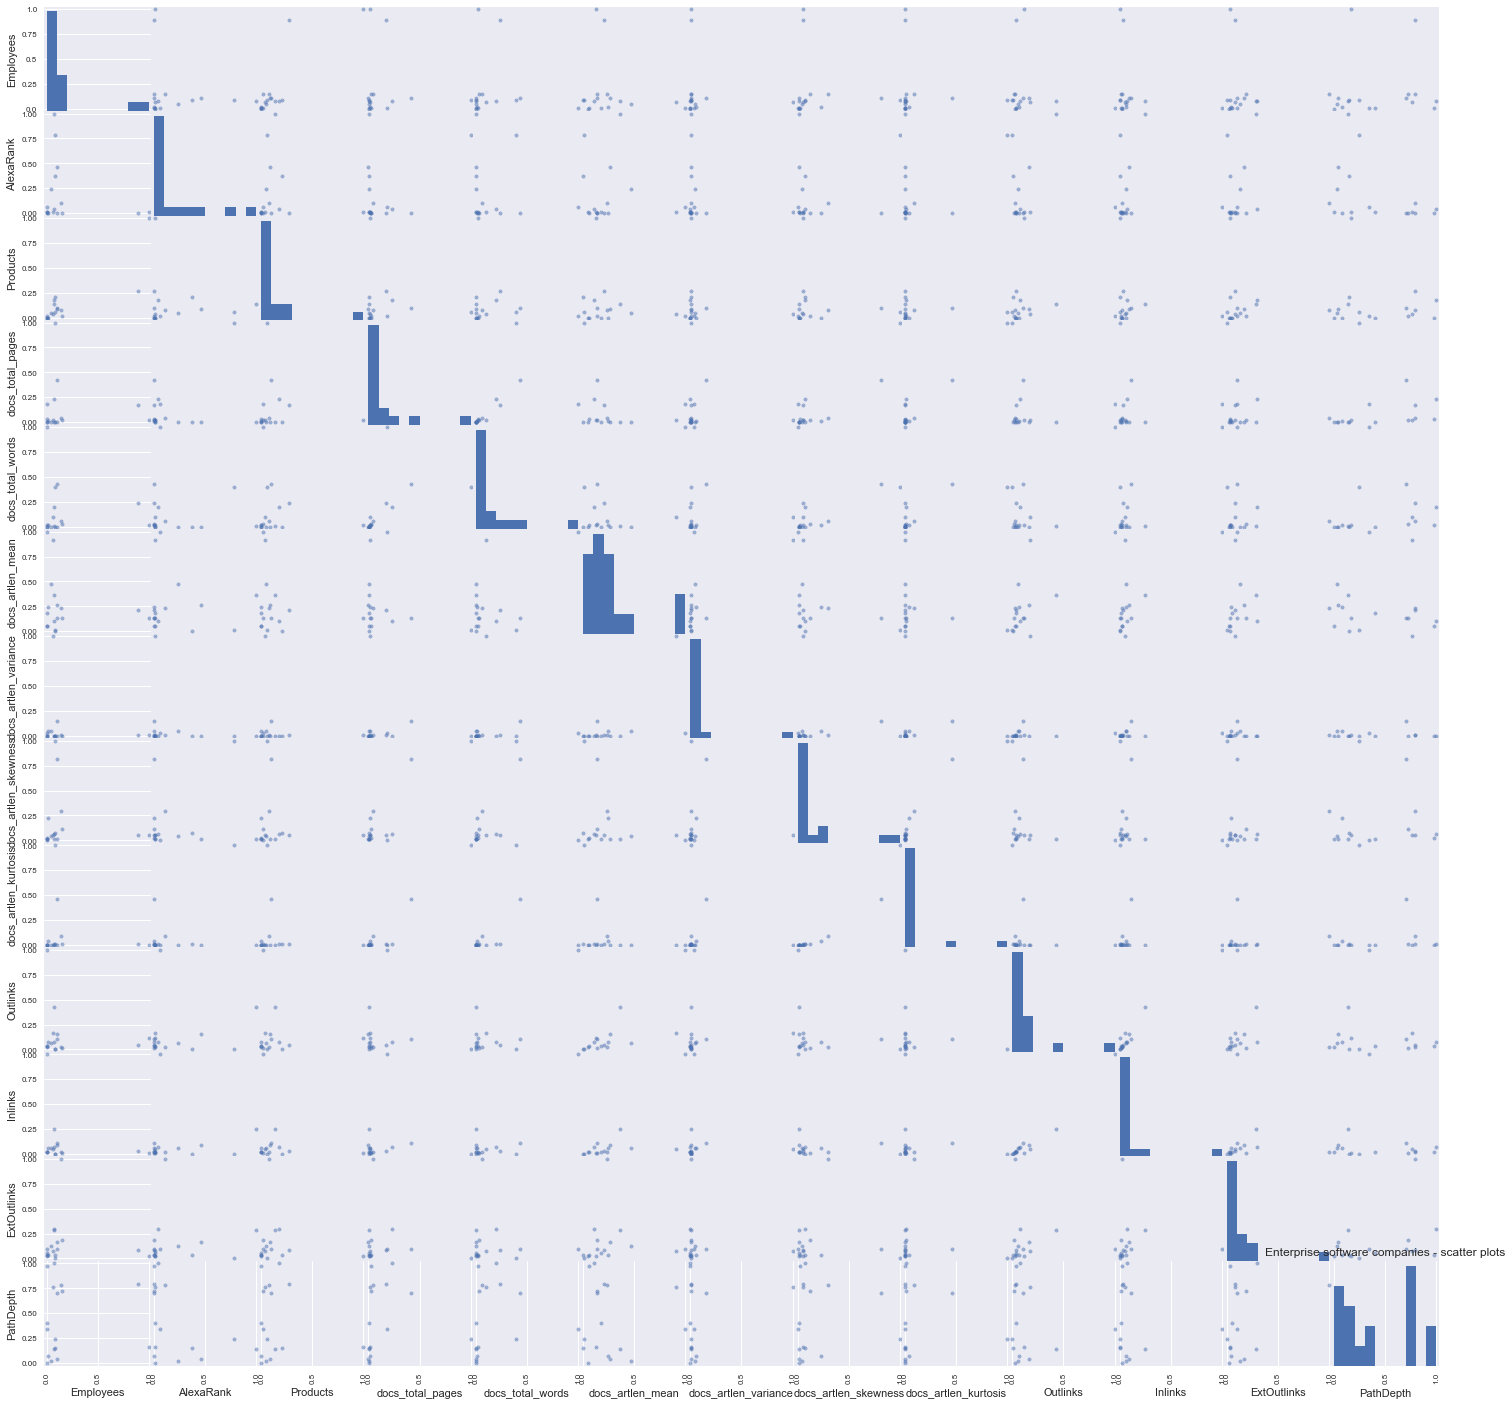

In [24]:
#normdf
fig = pd.scatter_matrix(normdf, figsize=(25,25))
plt.title('Enterprise software companies - scatter plots')
plt.savefig('graphs/ALL_ScatterPlotsNorm_01.png')

### 4. Cluster analysis
- Cluster analysis on article length mean and skew 

In [25]:
colsdiv = np.array(['#E50004','#DD8900','#9CD500','#12CE00','#00C66E','#0098BF','Blue'])
clustdf = pd.DataFrame(data = [ndf['docs_artlen_mean'], ndf['docs_artlen_skewness']])
# ,ndf['Outlinks']  ,ndf['docs_artlen_mean'], ,ndf['AlexaRank']
cldf = pd.DataFrame.transpose(clustdf)
X = cldf

In [26]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
import sklearn.metrics
import matplotlib.cm as cm

** a) Kmeans clustering and silhouette analysis **
Uses the example and graphs from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

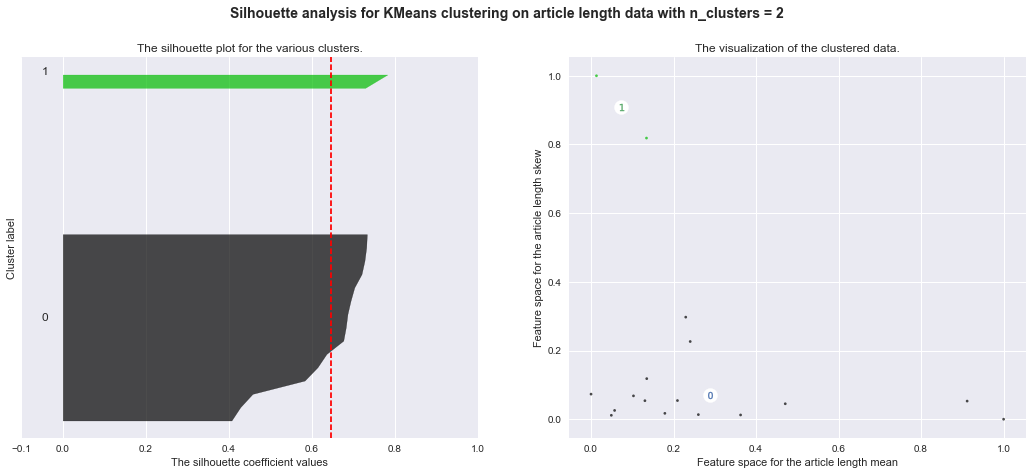

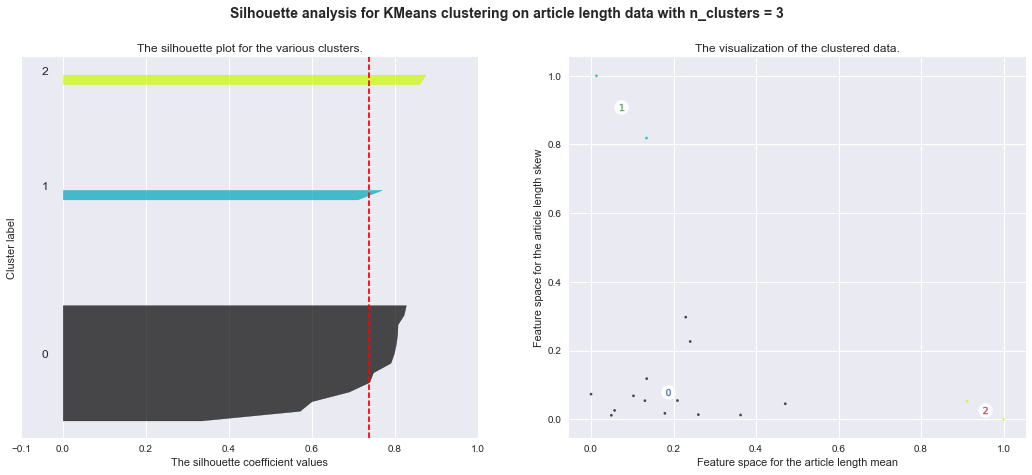

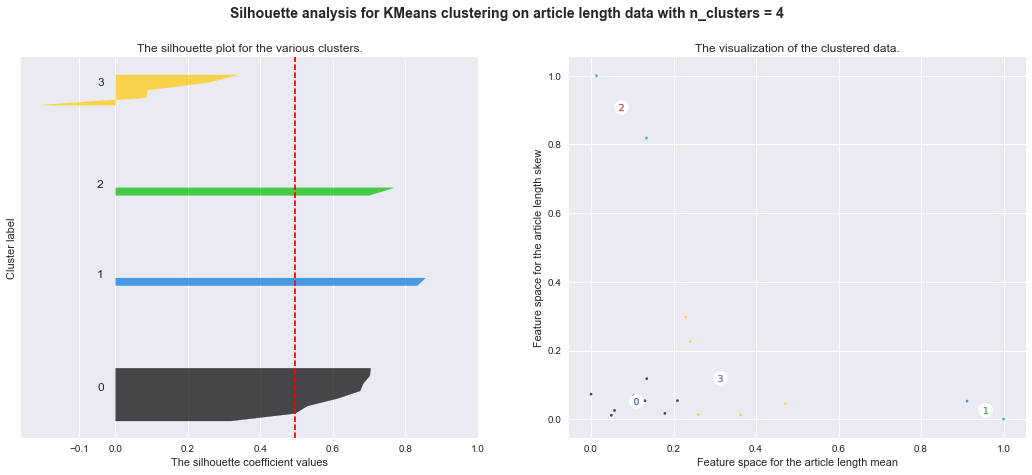

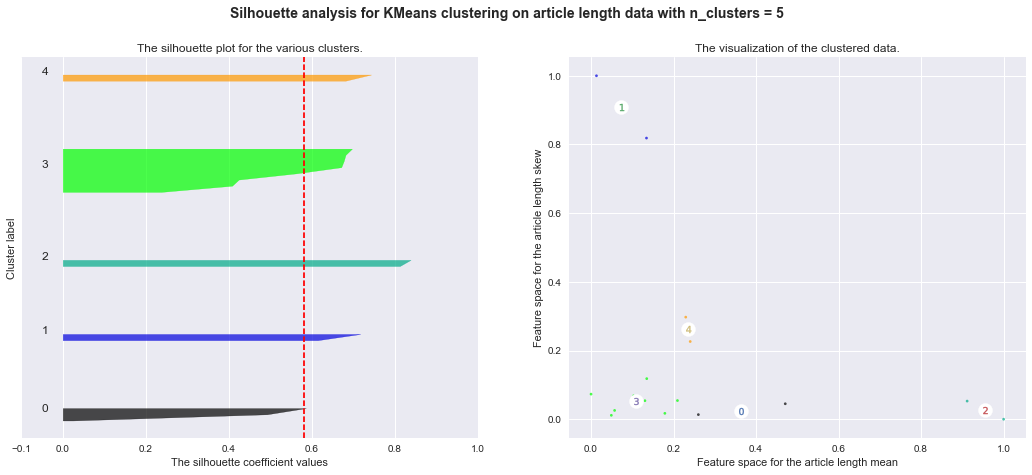

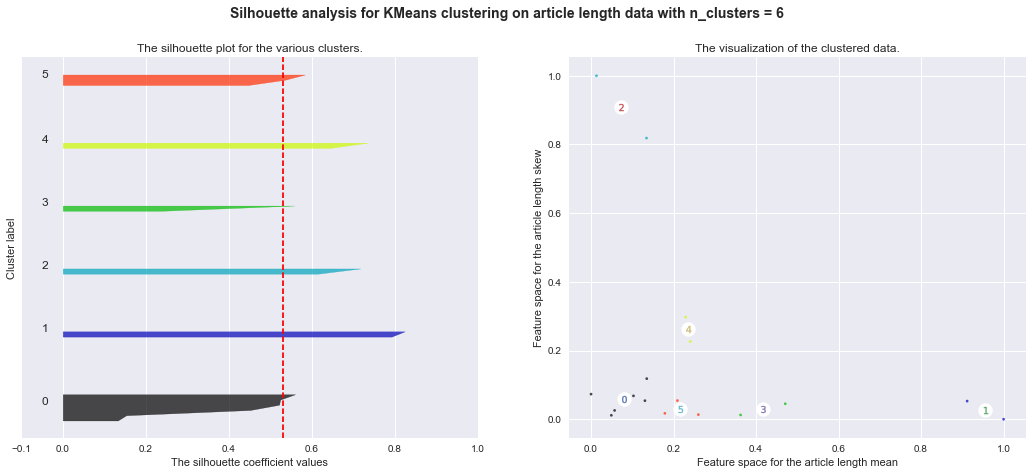

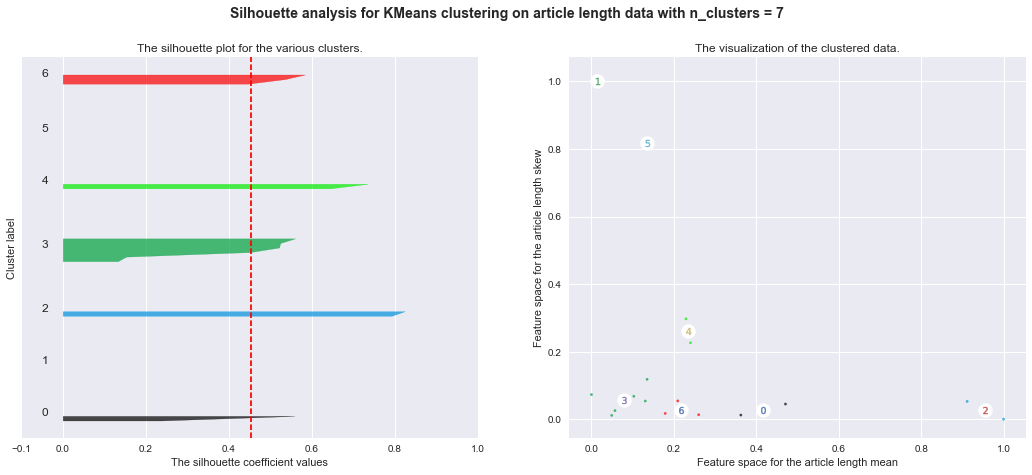

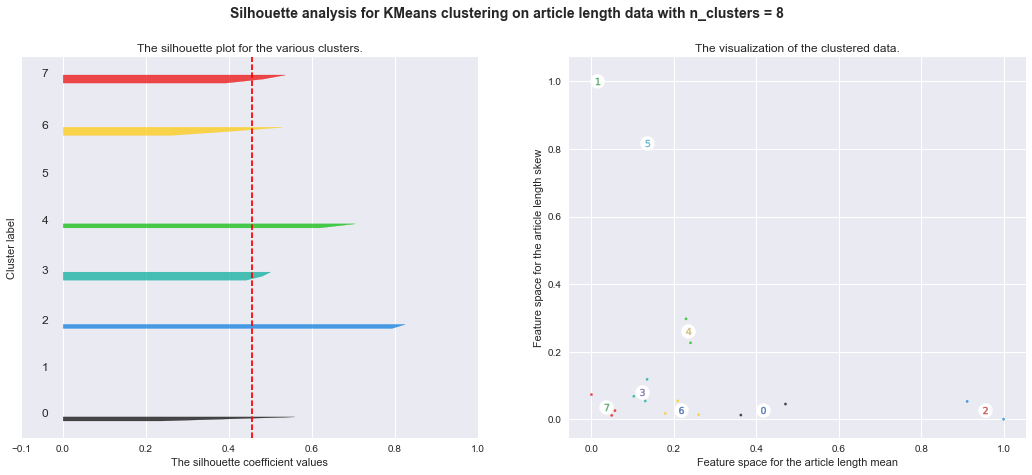

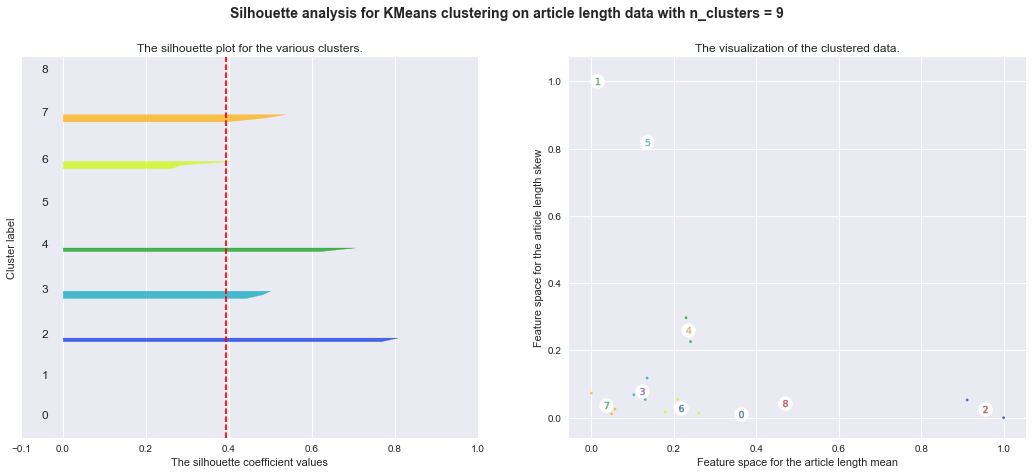

In [27]:
clust_array = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(cldf)
    silhouette_avg = sklearn.metrics.silhouette_score(cldf, cluster_labels)
    clust_array.append({'cnum':n_clusters,'centers':clusterer.cluster_centers_,'labels':cluster_labels,'silscore':silhouette_avg})
    sample_silhouette_values = sklearn.metrics.silhouette_samples(cldf, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples       
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X['docs_artlen_mean'], X['docs_artlen_skewness'], marker='.', s=30, lw=0, alpha=0.7,
    #ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)
    # Labeling the clusters
    centers = clusterer.cluster_centers_  
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the article length mean")
        ax2.set_ylabel("Feature space for the article length skew")
        plt.suptitle(("Silhouette analysis for KMeans clustering on article length data "
                  "with n_clusters = %d" % n_clusters % silhouette_avg),
                 fontsize=14, fontweight='bold')
        filnum = str(n_clusters)
        plt.savefig('graphs/ALL_ClusterTests_Clust_No-'+filnum+'.png')
    plt.show()

In [28]:
sildf = pd.DataFrame(clust_array)
sildf

,centers,cnum,labels,silscore
0,"[[0.289191614927, 0.0712509216466], [0.0737690...",2,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.646197
1,"[[0.186634891438, 0.0781515214083], [0.0737690...",3,"[0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, ...",0.737982
2,"[[0.10787977739, 0.0527070246079], [0.95581031...",4,"[0, 0, 0, 3, 2, 1, 0, 2, 0, 3, 3, 3, 1, 0, 0, ...",0.495427
3,"[[0.364445194794, 0.0236113712349], [0.0737690...",5,"[3, 3, 3, 4, 1, 2, 3, 1, 3, 0, 0, 0, 2, 3, 3, ...",0.580386
4,"[[0.0791144508391, 0.0583597526906], [0.955810...",6,"[5, 0, 0, 4, 2, 1, 0, 2, 0, 3, 3, 5, 1, 0, 5, ...",0.531185
5,"[[0.416601627481, 0.0287101526902], [0.0131488...",7,"[6, 3, 3, 4, 5, 2, 3, 1, 3, 0, 0, 6, 2, 3, 6, ...",0.452866
6,"[[0.416601627481, 0.0287101526902], [0.0131488...",8,"[6, 3, 3, 4, 5, 2, 7, 1, 3, 0, 0, 6, 2, 7, 6, ...",0.456043
7,"[[0.362446210846, 0.0123951911925], [0.0131488...",9,"[6, 3, 3, 4, 5, 2, 7, 1, 3, 0, 8, 6, 2, 7, 6, ...",0.392410


<Container object of 8 artists>

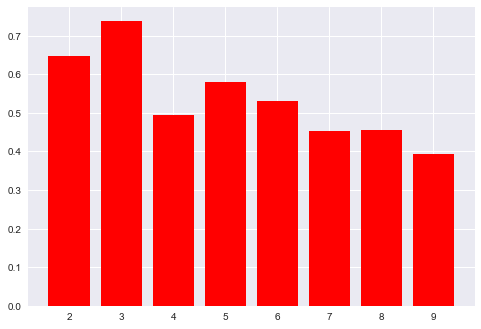

In [29]:
sil1 = range_n_clusters
sil2 = sildf['silscore']
plt.bar(sil1, sil2, color='red')

** b) 3D cluster plot**

### Plot article distributions by cluster

In [30]:
#clust_array
#Plot the most successful KMeans cluster
# 0-2, 1-3, 2-4, 3-5, 4-6, 5-7, 6-8, 7-9
carr = pd.DataFrame(clust_array)
carr['labels'][3]

array([3, 3, 3, 4, 1, 2, 3, 1, 3, 0, 0, 0, 2, 3, 3, 3, 4], dtype=int32)

In [31]:
clust_6 = carr['labels'][3]
cdf['KMeanGroup']= clust_6
t = pd.DataFrame(data=[cdf['KMeanGroup'],cdf['Company']])
tc = t.transpose() #<---- look at cluster groups
#tc['Cols'] = cols_hex[len(cdf)]
clust_num = 5
#tc

In [32]:
# prep for plot
c1_idx = tc[tc['KMeanGroup']==0]
c2_idx = tc[tc['KMeanGroup']==1]
c3_idx = tc[tc['KMeanGroup']==2]
c4_idx = tc[tc['KMeanGroup']==3]
c5_idx = tc[tc['KMeanGroup']==4]
c6_idx = tc[tc['KMeanGroup']==5]

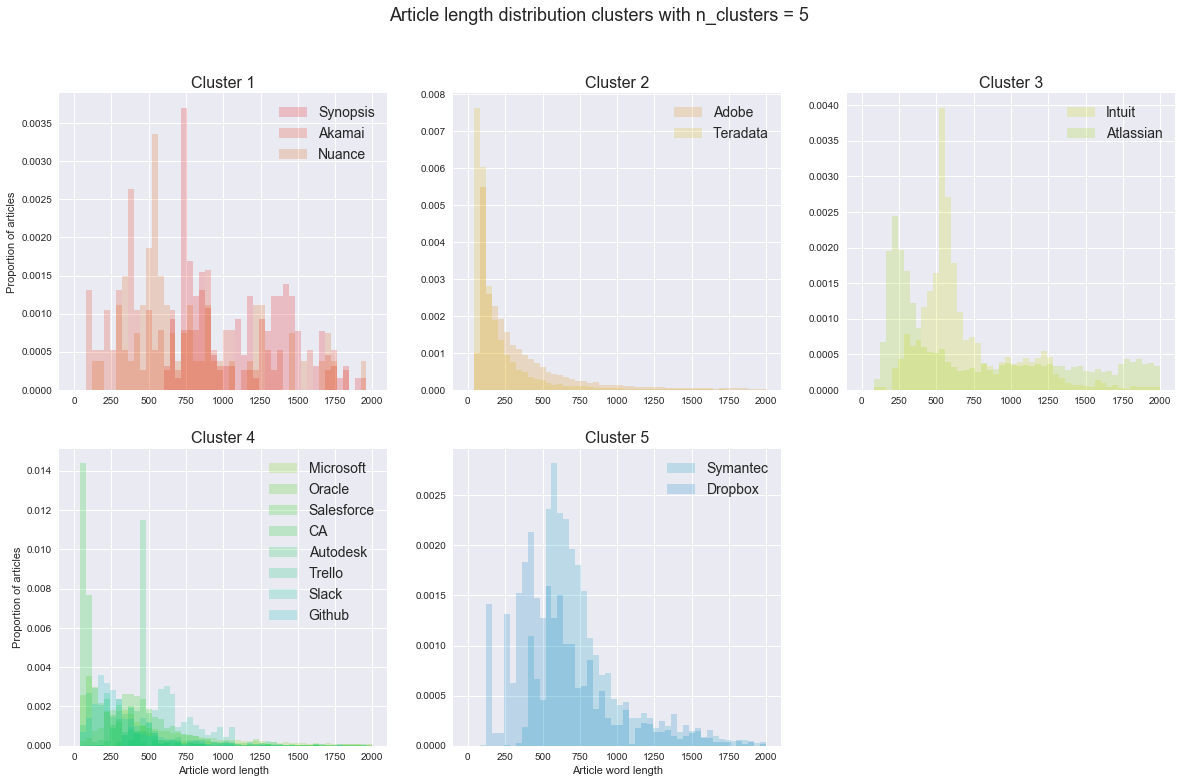

In [45]:
# Clusters = 5
plt.figure(figsize=(20, 12))
plt.suptitle(("Article length distribution clusters"
                  " with n_clusters = %d" % clust_num),
                 fontsize=18) #, fontweight='bold')
col_cnt = -1
# Upper Left
plt.subplot(231)
for c in range(0,len(c1_idx)):
    col_cnt = col_cnt + 1
    tmpi = c1_idx.index[c]
    get_nm = c1_idx.index[c]
    tlab = c1_idx.Company[get_nm]
    idx_col = cols_hex[col_cnt]
    plt.hist(xtmp[tmpi], bins, range=(0,2000), normed=True, alpha=0.2, label=tlab, color=idx_col)
plt.title('Cluster 1', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.ylabel('Proportion of articles')

# Upper Mid
plt.subplot(232)
for c in range(0,len(c2_idx)):
    col_cnt = col_cnt + 1
    tmpi = c2_idx.index[c]
    get_nm = c2_idx.index[c]
    tlab = c2_idx.Company[get_nm]
    idx_col = cols_hex[col_cnt]
    plt.hist(xtmp[tmpi], bins, range=(0,2000), normed=True, alpha=0.2, label=tlab, color=idx_col)
plt.title('Cluster 2', fontsize=16)
plt.legend(loc='upper right', fontsize=14)

# Upper right
plt.subplot(233)
for c in range(0,len(c3_idx)):
    col_cnt = col_cnt + 1
    tmpi = c3_idx.index[c]
    get_nm = c3_idx.index[c]
    tlab = c3_idx.Company[get_nm]
    idx_col = cols_hex[col_cnt]
    plt.hist(xtmp[tmpi], bins, range=(0,2000), normed=True, alpha=0.2, label=tlab, color=idx_col)
plt.title('Cluster 3', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
#plt.xlabel('Article word length')
#plt.ylabel('Proportion of articles')

# Mid Left
plt.subplot(234)
for c in range(0,len(c4_idx)):
    col_cnt = col_cnt + 1
    tmpi = c4_idx.index[c]
    get_nm = c4_idx.index[c]
    tlab = c4_idx.Company[get_nm]
    idx_col = cols_hex[col_cnt]
    plt.hist(xtmp[tmpi], bins, range=(0,2000), normed=True, alpha=0.2, label=tlab, color=idx_col)
plt.title('Cluster 4', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('Article word length')
plt.ylabel('Proportion of articles')

# Mid Mid
plt.subplot(235)
for c in range(0,len(c5_idx)):
    col_cnt = col_cnt + 1
    tmpi = c5_idx.index[c]
    get_nm = c5_idx.index[c]
    tlab = c5_idx.Company[get_nm]
    idx_col = cols_hex[col_cnt]
    plt.hist(xtmp[tmpi], bins, range=(0,2000), normed=True, alpha=0.2, label=tlab, color=idx_col)
plt.title('Cluster 5', fontsize=16)
plt.legend(loc='upper right', fontsize=14)
plt.xlabel('Article word length')

# # Mid Right
# plt.subplot(236)
# for c in range(0,len(c6_idx)):
#     col_cnt = col_cnt + 1
#     tmpi = c6_idx.index[c]
#     get_nm = c6_idx.index[c]
#     tlab = c6_idx.Company[get_nm]
#     idx_col = cols_hex[col_cnt]
#     plt.hist(xtmp[tmpi], bins, range=(0,2000), normed=True, alpha=0.2, label=tlab, color=idx_col)
# plt.title('Cluster 5')
# plt.legend(loc='upper right')
# plt.xlabel('Article word length')

plt.savefig('graphs/ALL_ArticleLengthDist_ClusterResults_01.png')